In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
import xgboost
%matplotlib inline
pd.set_option('display.max_colwidth',999)

C:\Users\p0key\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Make movement dictionary to use in vectorizor and a relationship dictionary to relate movement with movement class

In [2]:
def movements_data(csv_file):
    movements = pd.read_csv(csv_file, index_col = 'Unnamed: 0')
    # add movements that might have mulitple formats
    add_moves = [{'movement':'double-under','frequency':153,'move_class':'Monostructural','Equipment':'jump rope'},{'movement':'squat','frequency':63,'move_class':'Gymnastics','Equipment':'body'}]
    am = pd.DataFrame(add_moves)
    return pd.concat([movements,am], ignore_index=True)

In [3]:
def make_dicts(use): #fill in Dictionary needed 'CV', 'mgw', 'equip', or 'other'
    new_move = movements_data('movements.csv')
    
    if use == 'CV':
        move_dict = new_move.movement.to_dict()
        return dict((v,k) for k,v in move_dict.iteritems())
    
    if use == 'mgw' or use == 'equip':
        new_move_dict = new_move[['movement','move_class','Equipment']].to_dict(orient='records')
        relate_dict = {}
        equip_dict = {}
        for row in new_move_dict:
            relate_dict[row['movement']] = row['move_class']
            equip_dict[row['movement']] = row['Equipment']
        if use == 'equip':
            return equip_dict
        else:
            return relate_dict
    
    if use == 'other':
        eq_dict = new_move.Equipment.to_dict()
        other_dict = dict((v,k) for k,v in eq_dict.iteritems())
        bar = [k for k in other_dict.iterkeys()]
        for i,k in enumerate(bar):
            other_dict[k]=i
        return other_dict

### Read in initial data from Beyond the Whiteboard and locate the rows that represent workouts for time or for reps

In [4]:
#takes in data.csv from btwb and converts to the dataframe to use for the model
def model_df(data_csv):
    df = pd.read_csv(data_csv)
    df1 = df.loc[(df['Work performed'] > 0) & (df['Work time'] > 0) & (df['Work time'] < 3600000),:].copy()
    df1.drop(list(df1.loc[df1['Description'].str.contains('Every|Tabata'),:].index), inplace=True)
    df2 = df1.iloc[:].copy()
    return df2.reset_index(drop = True)

### Create functions to feed into Feature Union and Pipeline

In [5]:
def base_features_wt(df):
    return df[['Work time']]


base_features_wt_tf = FunctionTransformer(base_features_wt, validate=False)

In [6]:
def base_features_wp(df):
    return df[['Work performed']]

base_features_wp_tf = FunctionTransformer(base_features_wp, validate=False)

In [7]:
def get_movements(df):
    move_in_work = []
    new_move = movements_data('movements.csv')
    for w in [x for x in df['Description']]:
        moves = []
        row = {}
        for m in new_move.movement:
            if m in w.lower():
                moves.append(m)
        row['move'] = ', '.join(moves)
        move_in_work.append(row)
    return pd.DataFrame(move_in_work)['move']

get_movements_tf = FunctionTransformer(get_movements, validate=False)
        

In [8]:
def equipment_used(cell):
    equipment_used = []
    equip_list = cell.split(', ')
    equip_dict = make_dicts('equip')
    for x in equip_list:
        if x in equip_dict:
            equipment_used.append(equip_dict[x])
    return ', '.join(sorted(set(equipment_used))) 


In [9]:
def get_equip(df):
    return pd.DataFrame(get_movements(df).apply(equipment_used))['move']
    
get_equip_tf = FunctionTransformer(get_equip, validate=False)

In [10]:
def mgw_breakdown(cell):
    mgw = []
    move_list = cell.split(', ')
    relate_dict = make_dicts('mgw')
    for x in move_list:
        if x in relate_dict:
            mgw.append(relate_dict[x][0])
    return ''.join(sorted(set(mgw)))

In [11]:
def get_move_class(df):
    breakdown = pd.DataFrame(get_movements(df).apply(mgw_breakdown)) 
    for let in ['G','M','W']:
        breakdown[let] = breakdown['move'].apply(lambda x: 1 if re.search(let,x) else 0)
    return breakdown[['G','M','W']]

get_move_class_tf = FunctionTransformer(get_move_class, validate=False)

In [12]:
def time_or_reps(df):
    time_or_reps = pd.DataFrame(df['Formatted Result'].apply(lambda x: 'Time' if re.search(r'(min|sec)', x) else 'Reps'))
    return pd.get_dummies(time_or_reps, prefix='For')

time_or_reps_tf = FunctionTransformer(time_or_reps, validate=False)

In [13]:
def is_prescribed(df):
    return df['Prescribed'].apply(int).to_frame()

is_prescribed_tf = FunctionTransformer(is_prescribed, validate=False)    

In [14]:
def get_year(df):
    years = pd.Categorical(pd.to_datetime(df['Date']).dt.year, categories = range(2011,2018))
    return pd.get_dummies(years, columns=['Date'], prefix='Year')

get_year_tf = FunctionTransformer(get_year, validate=False)

In [15]:
def get_month(df):
    months = pd.DataFrame(pd.to_datetime(df['Date']).dt.month)
    return pd.get_dummies(months, columns=['Date'], prefix='Month')

get_month_tf = FunctionTransformer(get_month, validate=False)

In [68]:
def get_prediction(discription,wt,wp):
    #disription is workout discription, wt = worktime given for AMRAPs, wp = work performed for RFT
    df1 = model_df('data.csv')
    test = [{'Work time': wt, 'Description': discription, 'Work performed': wp}]
    df1 = df1.append(test, ignore_index=True)
    vect = TfidfVectorizer()

    tfid_matrix = vect.fit_transform(df1['Description'])
    des_distance = pairwise_distances(tfid_matrix, metric='cosine')
    new_df = pd.DataFrame(des_distance, index=df1.index.values, columns=df1['Description'].values)
    cos_sim = new_df[discription][new_df[discription]<.75]
    if len(cos_sim.shape) > 1  and cos_sim.shape[1] > 3:
        print 'looking at similars'
        s = new_df[discription].mean(axis=1)
        cos_sim = s[s<0.20]
#     #if cos_sim.min < 0.25:
        #cos_sim = cos_sim[cos_sim < 0.25]

    df_test=df1.iloc[list(cos_sim[:-1].index),:].copy()
#     print plt.scatter(df1['Work time'],df1['Work performed'])
#     return plt.scatter(df_test['Work time'], df_test['Work performed'])

    equip_pipeline = Pipeline([
        ('get_equip', get_equip_tf),
        ('eq_vect', CountVectorizer(vocabulary=make_dicts('eq'))),
        ('eq_nonsparse',FunctionTransformer(lambda X: X.toarray(), validate=False)) 
    ])
    vector_pipeline = Pipeline([
        ('get_movements', get_movements_tf),
        ('vect', CountVectorizer(vocabulary=make_dicts('CV'))),
        ('nonsparse',FunctionTransformer(lambda X: X.toarray(), validate=False)) 
    ])
    if wt:
        features_wt = FeatureUnion([
            #('get_month', get_month_tf),
            #('get_year', get_year_tf),
            ('equip_pipeline', equip_pipeline),
            #('is_prescribed', is_prescribed_tf),
            #('time_or_reps', time_or_reps_tf),
            ('get_move_class', get_move_class_tf),
            ('vector_pipeline', vector_pipeline),
            ('base_features_wt', base_features_wt_tf)
        ])
        pipe_wt = Pipeline([
            ('features_wt', features_wt),
            #('ss', StandardScaler()),
            #('lr', LinearRegression(fit_intercept=False, normalize=False))
            #('rf', RandomForestRegressor())
            ('gb', GradientBoostingRegressor(n_estimators=300,random_state=2008))
            #('dt', DecisionTreeRegressor())
        ])
        pipe_wt.fit(df_test,df_test['Work performed'])

        return pipe_wt.predict(pd.DataFrame(test))[0]
    if wp:
        features_wp = FeatureUnion([
            #('get_month', get_month_tf),
            #('get_year', get_year_tf),
            ('equip_pipeline', equip_pipeline),
            #('is_prescribed', is_prescribed_tf),
            #('time_or_reps', time_or_reps_tf),
            ('get_move_class', get_move_class_tf),
            ('vector_pipeline', vector_pipeline),
            ('base_features_wp', base_features_wp_tf)
        ])
        pipe_wp = Pipeline([
            ('features_wp', features_wp),
            #('ss', StandardScaler()),
            #('lr', LinearRegression(fit_intercept=False, normalize=True))
            #('rf', RandomForestRegressor(random_state=2008))
            ('gb', GradientBoostingRegressor(random_state=2008, n_estimators=300))
            #('dt', DecisionTreeRegressor())
        ])
        pipe_wp.fit(df_test,df_test['Work time'])
        return pipe_wp.predict(pd.DataFrame(test))[0]
    
    #pipe_wp.predict(df1.iloc[df1.shape[0]-1:df1.shape[0],:])[0]


In [17]:
def get_formatted_pred(discription, wt, wp, round_reps, round_work):
    raw_result = get_prediction(discription, wt, wp)
    print raw_result
    print discription
    #return raw_result
    if wt:
        tot_rounds = raw_result / round_work
        splits = str(tot_rounds).split('.')
        formatted_result = '{} rounds + {} reps'.format(splits[0],round(float('.'+splits[1])*round_reps,0))
        return formatted_result
    if wp:
        seconds = (raw_result / 1000)%60
        minutes = ((raw_result / 1000) - seconds)/60
        return '{} min, {} sec'.format(minutes,round(seconds,2))

In [40]:
get_formatted_pred(model_df('data_2.csv').iloc[0]['Description'],0,model_df('data_2.csv').iloc[0]['Work performed'], None, None)

932578.559038
21-15-9 reps of:
Squat Clean & Jerk, 75 lbs
Box Jump Over, 24 in


'15.0 min, 32.58 sec'

In [76]:
get_formatted_pred('20min AMRAP of:\n5 Pull-ups\n10 Push-ups\n15 Air Squats',1200000,None,30,8000)

80437.8438073
20min AMRAP of:
5 Pull-ups
10 Push-ups
15 Air Squats


'10 rounds + 2.0 reps'

In [63]:
get_formatted_pred('''4 rounds of:
20 Dumbbell Snatches, 35 lbs
10 Push-ups
Run, 200 m''',0,74482,None,None)

1296558.13716
4 rounds of:
20 Dumbbell Snatches, 35 lbs
10 Push-ups
Run, 200 m


'21.0 min, 36.56 sec'

In [69]:
get_formatted_pred('21-15-9 reps of:\nThruster, 65 lbs \nPull-up',0,32214,None,None)

307022.495016
21-15-9 reps of:
Thruster, 65 lbs 
Pull-up


'5.0 min, 7.02 sec'

In [70]:
get_formatted_pred('''5 rounds of:
5 Pull-ups
10 Banded Ring Dips
15 Wall Balls, 14 lb''',0,28930,None, None)

578428.341154
5 rounds of:
5 Pull-ups
10 Banded Ring Dips
15 Wall Balls, 14 lb


'9.0 min, 38.43 sec'

In [71]:
get_formatted_pred('''21-18-15-12-9-6-3 reps of:
Sumo Deadlift High-pull, 55 lbs
Overhead Squat, 55 lbs''',0,53747,None, None)

842132.069007
21-18-15-12-9-6-3 reps of:
Sumo Deadlift High-pull, 55 lbs
Overhead Squat, 55 lbs


'14.0 min, 2.13 sec'

In [72]:
get_formatted_pred('''5 rounds of:
5 Push Jerks, 95 lbs
10 Deadlifts, 95 lbs
15 Burpee Over Bars''',0,59605,None, None)

915511.016481
5 rounds of:
5 Push Jerks, 95 lbs
10 Deadlifts, 95 lbs
15 Burpee Over Bars


'15.0 min, 15.51 sec'

In [73]:
get_formatted_pred('''5 rounds of:
5 Pull-up (blue band)s
5 Ring Dip (Blue Band)s
21 Burpees''',0,62112,None, None)

1268698.93737
5 rounds of:
5 Pull-up (blue band)s
5 Ring Dip (Blue Band)s
21 Burpees


'21.0 min, 8.7 sec'

In [74]:
get_formatted_pred('''21-15-9 reps of:
Squat Clean & Jerk, 75 lbs
Box Jump Over, 24 in''', 0, 48908, None, None)

889015.104429
21-15-9 reps of:
Squat Clean & Jerk, 75 lbs
Box Jump Over, 24 in


'14.0 min, 49.02 sec'

In [75]:
get_formatted_pred('''10 rounds of:
9 Thrusters, 65 lbs
35 Double Unders''', 0,66776,None,None )

867657.803795
10 rounds of:
9 Thrusters, 65 lbs
35 Double Unders


'14.0 min, 27.66 sec'

In [736]:
def test_rows(d):
    foo = model_df(d)
    answ = []
    for i in range(foo.shape[0]):
        print i
        test = foo.iloc[i]
        df1 = foo.drop(foo.index[i]).copy()
        df1 = df1.append(test, ignore_index=True)

        discription = test['Description']
        vect = TfidfVectorizer()
        
        tfid_matrix = vect.fit_transform(df1['Description'])
        des_distance = pairwise_distances(tfid_matrix, metric='cosine')
        new_df = pd.DataFrame(des_distance, index=df1.index.values, columns=df1['Description'].values)
        cos_sim = new_df[discription][new_df[discription]<0.87]
        if len(cos_sim.shape) > 1 and cos_sim.shape[1] > 3:
            s = new_df[discription].mean(axis=1)
            cos_sim = s[s<0.25]
    #     #if cos_sim.min < 0.25:
            #cos_sim = cos_sim[cos_sim < 0.25]
        #print cos_sim.shape
        df_test=df1.iloc[list(cos_sim[:-1].index),:].copy()
        #print df_test['Description']

        equip_pipeline = Pipeline([
            ('get_equip', get_equip_tf),
            ('eq_vect', CountVectorizer(vocabulary=make_dicts('eq'))),
            ('eq_nonsparse',FunctionTransformer(lambda X: X.toarray(), validate=False)) 
        ])
        vector_pipeline = Pipeline([
            ('get_movements', get_movements_tf),
            ('vect', CountVectorizer(vocabulary=make_dicts('CV'))),
            ('nonsparse',FunctionTransformer(lambda X: X.toarray(), validate=False)) 
        ])
        if not re.search(r'(min|sec)',test['Formatted Result']):
            
            features_wt = FeatureUnion([
                #('get_month', get_month_tf),
                #('get_year', get_year_tf),
                ('equip_pipeline', equip_pipeline),
                #('is_prescribed', is_prescribed_tf),
                #('time_or_reps', time_or_reps_tf),
                ('get_move_class', get_move_class_tf),
                ('vector_pipeline', vector_pipeline),
                ('base_features_wt', base_features_wt_tf)
            ])
            pipe_wt = Pipeline([
                ('features_wt', features_wt),
                #('ss', StandardScaler()),
                #('lr', LinearRegression(fit_intercept=False, normalize=True))
                #('rf', RandomForestRegressor())
                ('gb', GradientBoostingRegressor())
                #('dt', DecisionTreeRegressor())
            ])
            pipe_wt.fit(df_test,df_test['Work performed'])

            answ.append(pipe_wt.predict(df1.iloc[df1.shape[0]-1:df1.shape[0],:])[0])
        if re.search(r'(min|sec)',test['Formatted Result']):
            features_wp = FeatureUnion([
                #('get_month', get_month_tf),
                #('get_year', get_year_tf),
                ('equip_pipeline', equip_pipeline),
                #('is_prescribed', is_prescribed_tf),
                #('time_or_reps', time_or_reps_tf),
                ('get_move_class', get_move_class_tf),
                ('vector_pipeline', vector_pipeline),
                ('base_features_wp', base_features_wp_tf)
            ])
            pipe_wp = Pipeline([
                ('features_wp', features_wp),
                #('ss', StandardScaler()),
                #('lr', LinearRegression(fit_intercept=False, normalize=True))
                #('rf', RandomForestRegressor())
                ('gb', GradientBoostingRegressor())
                #('dt', DecisionTreeRegressor())
            ])
            pipe_wp.fit(df_test,df_test['Work time'])
            answ.append(pipe_wp.predict(df1.iloc[df1.shape[0]-1:df1.shape[0],:])[0])
    return answ

In [396]:
from sklearn.metrics import r2_score

In [33]:
blah = model_df('data_2.csv').iloc[:17]
to_score = pd.concat([blah,time_or_reps(blah)], axis=1) 
to_score

,Date,Workout,Result,Prescribed,Pukie,Work performed,Work time,Formatted Result,Notes,Description,For_Reps,For_Time
0,2017-05-20,21-15-9: Squat Clean & Jerks and Box Jump Overs,763000.000,True,False,48876,763000.0,12 mins 43 secs,NaN,"21-15-9 reps of:\nSquat Clean & Jerk, 75 lbs\nBox Jump Over, 24 in",0,1
1,2017-05-06,AMRAP 7 mins: Pull-ups and Box Jumps,3.350,True,False,19977,420000.0,3 rounds + 7 Pull-ups | 67 reps,NaN,"7:00 AMRAP:\n10 Pull-ups\n10 Box Jumps, 20 in",1,0
2,2017-05-06,AMRAP 7 mins: Banded Ring Dips and Wall Balls,3.429,False,False,16418,420000.0,3 rounds + 6 Ring Push-ups | 57 reps,NaN,"7:00 AMRAP:\n7 Ring Push-ups\n10 Wall Balls, 8 lbs",1,0
3,2017-05-06,"AMRAP 12 mins: Back Squats, Russian Kettlebell Swings, Back Squats and Push-ups",3.125,False,False,29820,720000.0,3 rounds + 5 Back Squats | 155 reps,NaN,"12:00 AMRAP:\n10 Back Squats, 95 lbs\n10 Russian Kettlebell Swings, 53 lbs\n10 Back Squats, 95 lbs\n20 Push-up (knees)s",1,0
4,2017-05-05,Clean & Jerk : 30 Reps for Time,123000.000,True,False,19921,123000.0,2 mins 3 secs,NaN,"30 Clean & Jerks, 65 lbs",0,1
5,2017-05-02,"Row : 250/500/750/1000/1000/750/500/250 m, rest 30 secs",1383000.000,True,False,135009,1383000.0,23 mins 3 secs,2:18.6 avg 500m pace avg 24spm,"Intervals : rest 30 secs\nRow, 250 m | 1:10\nRow, 500 m | 2:21\nRow, 750 m | 3:28\nRow, 1000 m | 4:37\nRow, 1000 m | 4:36\nRow, 750 m | 3:27\nRow, 500 m | 2:17\nRow, 250 m | 1:07",0,1
6,2017-04-30,"5 RFT: Push Jerks, Deadlifts and Burpee Over Bars",917000.000,True,False,59621,917000.0,15 mins 17 secs,NaN,"5 rounds of:\n5 Push Jerks, 95 lbs\n10 Deadlifts, 95 lbs\n15 Burpee Over Bars",0,1
7,2017-04-25,"5 RFT: Pull-ups, Ring Dips and Burpees",960000.000,False,False,62120,960000.0,16 mins,"Pull ups and dips with band, accidentally only did 5 of each",5 rounds of:\n5 Pull-up (blue band)s\n5 Ring Dip (Blue Band)s\n21 Burpees,0,1
8,2017-04-23,"AMRAP 13 mins: Back Rack Walking Lunges, Dumbbell Snatches, Back Rack Walking Lunges and Ring Rows",2.650,True,False,16444,780000.0,2 rounds + 25 yd + 14 Dumbbell Snatches + 15 yd,NaN,"13:00 AMRAP:\nBack Rack Walking Lunge, 65 lbs, 25 yd\n14 Dumbbell Snatches, 20 lbs\nBack Rack Walking Lunge, 65 lbs, 25 yd\n5 Ring Rows",1,0
9,2017-04-22,"AMRAP 20 mins: Rope Climb (from ground to standing)s, 400 m and Piked Handstand Push Up On Boxes",58.000,True,False,47953,1200000.0,"58 reps | 15, 15, 13, and 15",NaN,"20:00 AMRAP:\n1 Rope Climb (from ground to standing)\nRun, 400 m\nmax rep Piked Handstand Push Up On Boxes",1,0


In [34]:
preds = []
for i in range(blah.shape[0]):
    if to_score.iloc[i]['For_Time'] == 1:
        x = get_prediction(model_df('data_2.csv').iloc[i]['Description'],None,model_df('data_2.csv').iloc[i]['Work performed'])
        preds.append(x)
    elif to_score.iloc[i]['For_Time'] == 0:
        x = get_prediction(model_df('data_2.csv').iloc[i]['Description'],model_df('data_2.csv').iloc[i]['Work time'],None)
        preds.append(x)
to_score['pred'] = preds
to_score

,Date,Workout,Result,Prescribed,Pukie,Work performed,Work time,Formatted Result,Notes,Description,For_Reps,For_Time,pred
0,2017-05-20,21-15-9: Squat Clean & Jerks and Box Jump Overs,763000.000,True,False,48876,763000.0,12 mins 43 secs,NaN,"21-15-9 reps of:\nSquat Clean & Jerk, 75 lbs\nBox Jump Over, 24 in",0,1,9.325786e+05
1,2017-05-06,AMRAP 7 mins: Pull-ups and Box Jumps,3.350,True,False,19977,420000.0,3 rounds + 7 Pull-ups | 67 reps,NaN,"7:00 AMRAP:\n10 Pull-ups\n10 Box Jumps, 20 in",1,0,2.222045e+04
2,2017-05-06,AMRAP 7 mins: Banded Ring Dips and Wall Balls,3.429,False,False,16418,420000.0,3 rounds + 6 Ring Push-ups | 57 reps,NaN,"7:00 AMRAP:\n7 Ring Push-ups\n10 Wall Balls, 8 lbs",1,0,1.292579e+04
3,2017-05-06,"AMRAP 12 mins: Back Squats, Russian Kettlebell Swings, Back Squats and Push-ups",3.125,False,False,29820,720000.0,3 rounds + 5 Back Squats | 155 reps,NaN,"12:00 AMRAP:\n10 Back Squats, 95 lbs\n10 Russian Kettlebell Swings, 53 lbs\n10 Back Squats, 95 lbs\n20 Push-up (knees)s",1,0,1.431516e+04
4,2017-05-05,Clean & Jerk : 30 Reps for Time,123000.000,True,False,19921,123000.0,2 mins 3 secs,NaN,"30 Clean & Jerks, 65 lbs",0,1,2.154109e+05
5,2017-05-02,"Row : 250/500/750/1000/1000/750/500/250 m, rest 30 secs",1383000.000,True,False,135009,1383000.0,23 mins 3 secs,2:18.6 avg 500m pace avg 24spm,"Intervals : rest 30 secs\nRow, 250 m | 1:10\nRow, 500 m | 2:21\nRow, 750 m | 3:28\nRow, 1000 m | 4:37\nRow, 1000 m | 4:36\nRow, 750 m | 3:27\nRow, 500 m | 2:17\nRow, 250 m | 1:07",0,1,1.014400e+06
6,2017-04-30,"5 RFT: Push Jerks, Deadlifts and Burpee Over Bars",917000.000,True,False,59621,917000.0,15 mins 17 secs,NaN,"5 rounds of:\n5 Push Jerks, 95 lbs\n10 Deadlifts, 95 lbs\n15 Burpee Over Bars",0,1,9.176168e+05
7,2017-04-25,"5 RFT: Pull-ups, Ring Dips and Burpees",960000.000,False,False,62120,960000.0,16 mins,"Pull ups and dips with band, accidentally only did 5 of each",5 rounds of:\n5 Pull-up (blue band)s\n5 Ring Dip (Blue Band)s\n21 Burpees,0,1,5.155533e+05
8,2017-04-23,"AMRAP 13 mins: Back Rack Walking Lunges, Dumbbell Snatches, Back Rack Walking Lunges and Ring Rows",2.650,True,False,16444,780000.0,2 rounds + 25 yd + 14 Dumbbell Snatches + 15 yd,NaN,"13:00 AMRAP:\nBack Rack Walking Lunge, 65 lbs, 25 yd\n14 Dumbbell Snatches, 20 lbs\nBack Rack Walking Lunge, 65 lbs, 25 yd\n5 Ring Rows",1,0,1.372772e+04
9,2017-04-22,"AMRAP 20 mins: Rope Climb (from ground to standing)s, 400 m and Piked Handstand Push Up On Boxes",58.000,True,False,47953,1200000.0,"58 reps | 15, 15, 13, and 15",NaN,"20:00 AMRAP:\n1 Rope Climb (from ground to standing)\nRun, 400 m\nmax rep Piked Handstand Push Up On Boxes",1,0,6.886585e+04


In [35]:
time_index = to_score['For_Reps'][to_score['For_Reps'] == 0].index
reps_index = to_score['For_Reps'][to_score['For_Reps'] == 1].index

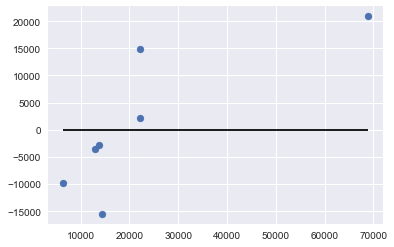

In [36]:
pred = to_score['pred'][reps_index]
y_test = to_score['Work performed'][reps_index]
plt.scatter(pred, pred - y_test)
plt.hlines(y = 0, xmin= pred.min(), xmax=pred.max())

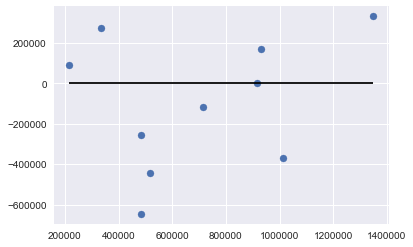

In [37]:
pred = to_score['pred'][time_index]
y_test = to_score['Work time'][time_index]
plt.scatter(pred, pred - y_test)
plt.hlines(y = 0, xmin= pred.min(), xmax=pred.max())

In [38]:
print r2_score(to_score['Work performed'][reps_index],to_score['pred'][reps_index])
print r2_score(to_score['Work time'][time_index],to_score['pred'][time_index])

NameError: name 'r2_score' is not defined